# VIDUS Viral Load Genotype PCA: troubleshooting
**Author:** Jesse Marks

**GitHub Issue:** [#102](https://github.com/RTIInternational/bioinformatics/issues/102)

This notebook documents the steps taken to perform a PCA on the observed genotype data for VIDUS. We then calculate the PVE of the genotype PCs for the phenotype `viral load`. 

## Data Description
### Genotype data
The post-qc observed genotype data was downloaded from S3:
`s3://rti-hiv/vidus/data/genotype/observed/final/ea_chr_all.{bed,bim,fam}.gz`

Eric Early pointed me to the subset of data (n=207) on his EC2 instance at the location:
`/rti-hiv/vidus/data/genotype/observed/final`

We downloaded the FAM file from this location (vl_n_207.pruned.fam) and used this to prune down the genotype data to 207 samples. We also used this fam file to filter down the phenotype file. 

### phenotype data
Eric Early sent me the phenotype file from his personal computer. This file was named:
`VIDUS RNAseq samples selected_v3_VL.csv`

We used the FAM file mentioned above to filter these data (n=215) down to the n=207 samples.

## Process genotype data
Filter down to 207 samples.

In [ ]:
## Download full post-qc observed genotypes
cd /shared/jmarks/hiv/vidus/troubleshooting
aws s3 sync s3://rti-hiv/vidus/data/genotype/observed/final/ .
gunzip *

## copy vl_n_207.pruned.fam from Eric Early's instance to get subset
cut -d" " -f1,2 vl_n_207.pruned.fam  > n207_ids.txt

## use plink to filter to these data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile  original/ea_chr_all \
    --keep early/n207_ids.txt \
    --make-bed \
    --out eig/vidus.ea.genotypes

## Process phenotype file
Filter down to 207 samples and variables of interest. 

```
head vidus_n207_final.tsv

iid     vl_mean female  ageatint
8005964579_NA0054695_93-0482    50500   0       64
8005964583_NA0053919_93-0005    28820.25        0       40
8005964594_NA0054312_93-0257    64102.5 0       51

```

In [ ]:
## python ## 
"""
This python script filters the phenotype file down to the samples of interest and also the variables of interest. 
The variables we want from the phenotype file are (in this specific order):

id column (iid)
phenotype column (vllog10_mean)
sex column (female)
age column (ageatint)
"""

infile = "../VIDUS RNAseq samples selected_v3_VL.csv" # phenotype file E.E. sent
inf2 = "vl_n_207.pruned.fam" # genotype fam file that we want to filter the phenotype to
outfile = "vidus_n207_final.tsv"

with open(infile) as inF, open(inf2) as inF2, open(outfile, "w") as outF:
    head = inF.readline()
    head = head.strip().split(",")

    iidcol = 8
    vllog10_mean = 2
    female = 5
    ageatint = 6

    pheno_dic = {}
    line = inF.readline()
    # create a dictionary with the information (columns) we want from the phenotype file
    while line:
        sl = line.strip().split(",")
        newline = "{}\t{}\t{}\t{}\n".format(sl[iidcol], sl[vllog10_mean], sl[female], sl[ageatint])
        pheno_dic[sl[iidcol]] = newline
        line = inF.readline()

    line2 = inF2.readline()
    outhead = "{}\t{}\t{}\t{}\n".format(head[iidcol], head[vllog10_mean], head[female], head[ageatint])
    outF.write(outhead)
    # loop through FAM file to get specific samples from above dictionary
    while line2:
        sl2 = line2.strip().split()
        outF.write(pheno_dic[sl2[0]])
        line2 = inF2.readline()

### Quantile
Partitions phenotype variable into quintiles.

In [58]:
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/troubleshooting/pca/20190725/n207/")

mytable <- read.table("vidus_n207_final.tsv", header=T)

vl <- mytable$vllog10_mean
vl_bins <- cut(x = vl, breaks = 5, labels = FALSE)
mytable$bin_vllog10_mean <- vl_bins
#mytable$vllog10_mean <- NULL
head(mytable)
write.table(mytable, "vidus_n207_final_binned.tsv", quote = FALSE, row.names = FALSE)

iid,vllog10_mean,female,ageatint,bin_vllog10_mean
8005964579_NA0054695_93-0482,4.529213,0,64,3
8005964583_NA0053919_93-0005,4.420590,0,40,3
8005964594_NA0054312_93-0257,4.708277,0,51,3
8005964602_NA0054507_93-0379,4.647480,1,55,3
8005964603_NA0054701_93-0488,6.929174,0,25,5
8005964604_NA0054654_93-0109,3.228047,0,55,2


## Run PCA

Run the following script to produce the PCA for the genotype results.
`bash _methods_vidus_pca_20190725.sh &> pca_log.log`

In [ ]:
#!/bin/bash

## Set global variables ##
anlist="ea" # "ea", "aa", or "ea aa"
study="vidus"
case_control="false"  # true if (case control phenotype) false if (not)
procD="/shared/jmarks/hiv/vidus/troubleshooting/n207"  # processing directory
eig="$procD/eig" # do not alter
mkdir -p $eig/results # do not alter


## Genotype Data should be in the directory $eig
## The genotype data names should be of the form: $study.$an.genotype.{bed,bim,fam}. For Example:
## vidus.ea.genotype.bim, vidus.ea.genotype.bed, vidus.ea.genotype.fam


# Do not edit below this line
################################################################################
################################################################################

## Remove high-LD region variants ##
for an in $anlist; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/$study.$an.genotypes.bim > $eig/$study.$an.genotypes.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes \
        --exclude $eig/$study.$an.genotypes.high_ld_regions.remove \
        --make-bed \
        --out $eig/$study.$an.genotypes.high_ld_regions_removed
done

## Linkage disequilibrium pruning ##
for an in $anlist;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${an}_chr${chr}_ld_pruned
    done
done

## Merge *prune.in files ##
for an in $anlist; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/$study.$an.genotypes.ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex


## Rename BIM/FAM file IDs ##
for an in $anlist;do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.fam \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.fam

    ## Rename BIM file IDs ##
    awk '{$2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.bim \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.bim
done

## Assign Case/Control to FAM file if applicable ##
if [ $case_control == "true" ]; then
    for an in $anlist; do
        pfile=$procD/$study_${an}_phenotype_for_pca.txt

        ## extract the IDs of controls
        tail -n +2 $pfile |\
            awk '{ if ($2==0) {print $1}}' > $eig/$an.controls.ids

        # Modify FAM file to include case/control status
        awk 'NR==FNR{map[$1] = $1; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
            $eig/$an.controls.ids $eig/$study.$an.genotypes.ld_pruned_renamed.fam >\
            $eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam
    done
fi

## run eigenstrat ##
for an in $anlist; do
    if [ $case_control == "true" ]; then
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam"
    else
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed.fam"
    fi
    bimfile="$eig/$study.$an.genotypes.ld_pruned_renamed.bim"
    bedfile="$eig/$study.$an.genotypes.ld_pruned.bed"

    /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${an}_ld_pruned.pca \
        -p $eig/results/${an}_ld_pruned.plot \
        -e $eig/results/${ancestry}_ld_pruned.eval \
        -l $eig/results/${ancestry}_ld_pruned.pca.log \
        -m 0
done

## Extract eigenvectors (top 10 PCs) ##
for an in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${an}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
done


## Next produce PCA plots

## PC Selection 

### View PCs from EIGENSTRAT
Copy results over to local machine.

In [ ]:
### bash ###
cd /cygdrive/c/Users/jmarks/Desktop/Projects/HIV/vidus/troubleshooting/pca/20190725/n207
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/hiv/vidus/troubleshooting/eig/results/* .

In [1]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/troubleshooting/pca/20190725/n207")
options(stringsAsFactors = F)
ea.evec <- read.table("ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
head(ea.evec[,1:5])
tail(ea.evec[,1:5])

,V2,V3,V4,V5,V6
ID_1:ID_1,0.0113,0.0051,-0.0208,-0.0793,-0.0329
ID_2:ID_2,-0.5020,0.2573,0.1191,-0.2105,0.2833
ID_3:ID_3,0.0275,-0.0002,-0.0030,0.0419,0.0158
ID_4:ID_4,0.0364,0.0213,0.0161,-0.0120,-0.0289
ID_5:ID_5,0.0072,-0.0106,-0.0056,-0.0009,0.0109
ID_6:ID_6,0.0306,-0.0219,-0.0210,0.0143,0.0142


,V2,V3,V4,V5,V6
ID_202:ID_202,0.0235,-0.0253,-0.0344,-0.0838,0.0229
ID_203:ID_203,-0.0132,0.0112,0.0106,-0.0543,-0.0128
ID_204:ID_204,0.0193,0.0061,-0.0395,-0.0001,-0.0045
ID_205:ID_205,0.0203,0.0017,-0.0261,0.0640,-0.0204
ID_206:ID_206,0.0236,0.0079,-0.0121,0.0061,0.0108
ID_207:ID_207,0.0318,-0.0029,-0.0126,-0.0288,-0.0139


### Plot top10 PCs

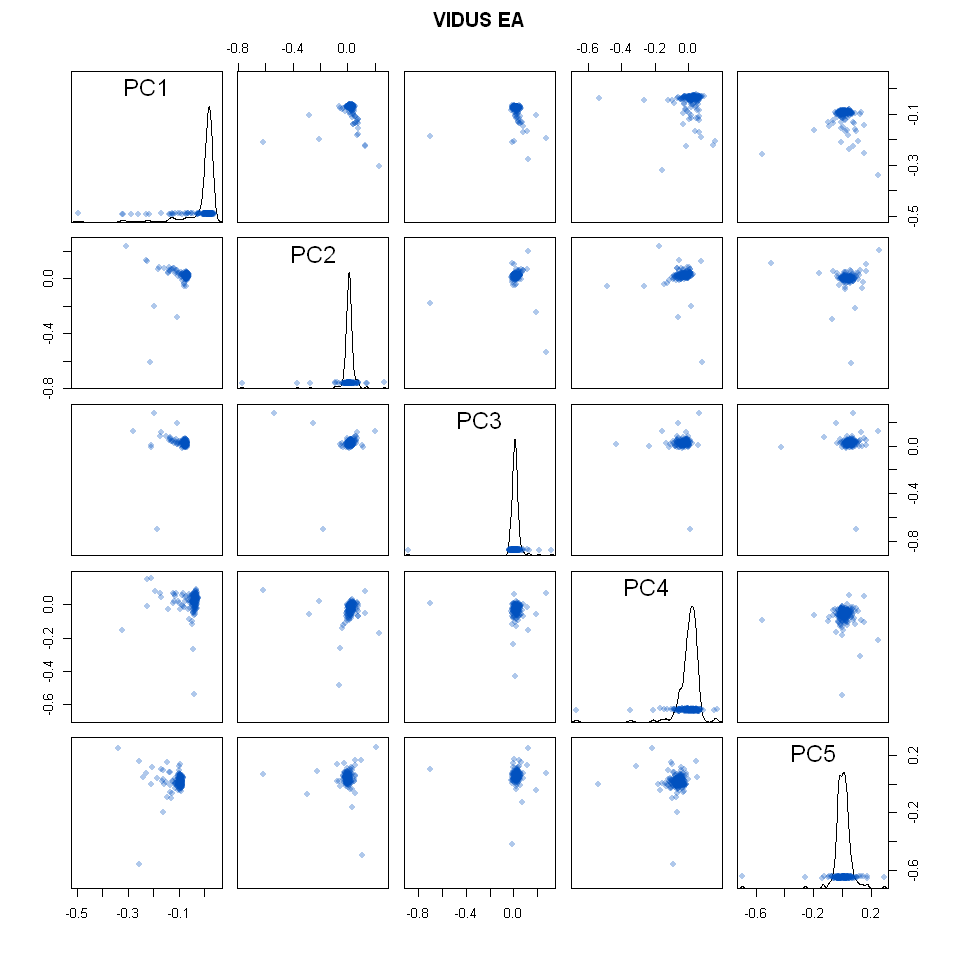

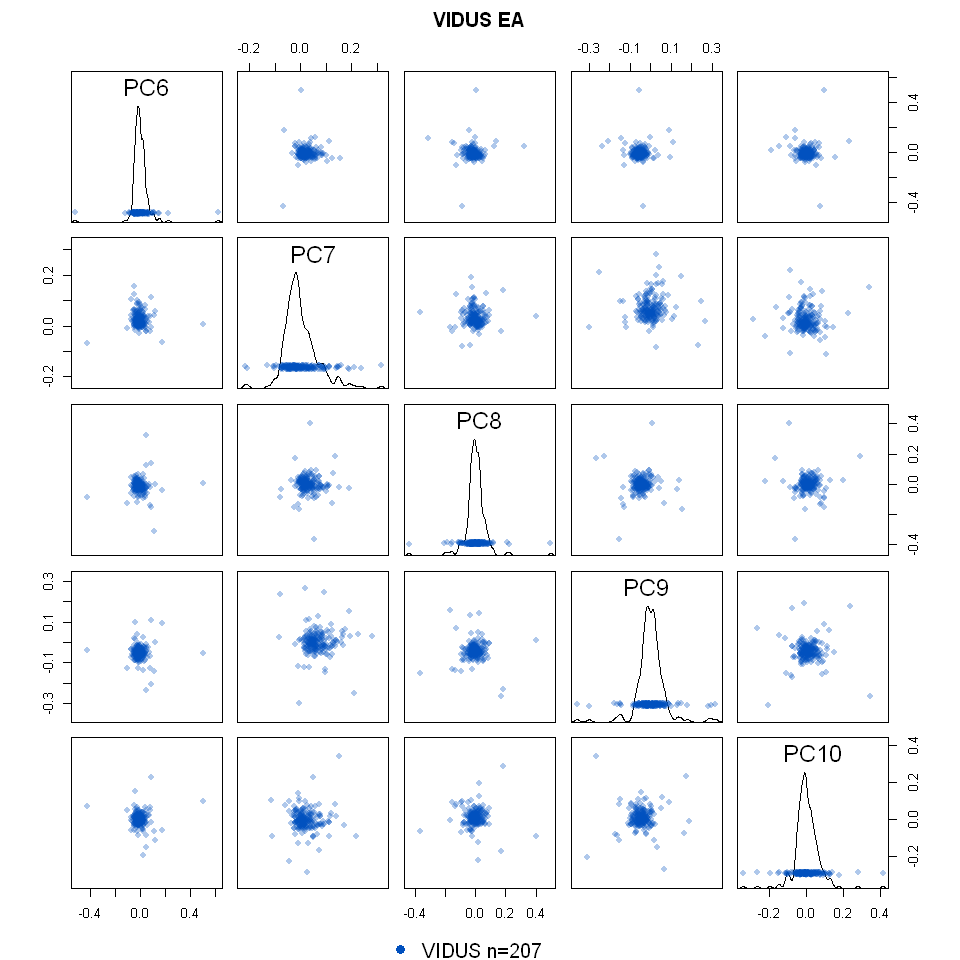

In [2]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    # Make x and y axes equal
    limits <- c(min(x, y), max(x, y)) * 1.3
    par(usr = c(limits, limits))
    points(x, y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    # Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    # Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

# Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

# Color label samples
sample.names <- ea.evec[,11]
label.colors <- rep(NA, length(sample.names))
#label.colors[grepl(x=sample.names, pattern="Case", ignore.case=T)] <- rgb(0,80,190,80, maxColorValue=255) #blue
#label.colors[grepl(x=sample.names, pattern="Control", ignore.case=T)] <- rgb(200,0,0,80, maxColorValue=255) #red
legend.cols <- c(rgb(0,80,190,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255))

label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="VIDUS EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="VIDUS EA", cex.main=1)
#legend("bottom", c("Cases", "Controls"), 
legend("bottom", c("VIDUS n=207"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)


#--------------------------------------------------------------------------------


### Highlight Potential Outliers
Eric Otto Johnson requested that we hightlight the samples
```
0110, 0369, 0045, and 0531
```
who had early been identified as potential outliers.

**Note:** For the highlight list, you should supply a vector of samples to highlight in red. The integer number associated with the sample should be provided in this vector. The integer number is the order in which that sample appears in the output of the PCA analysis. You should be able to `grep -n <sample_number>` in the FAM file to get the order in which the sample appears in the `ea_ld_pruned.pca.evec` results file.

In [10]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/troubleshooting/pca/20190725/n207")
options(stringsAsFactors = F)
ea_evec <- read.table("ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)

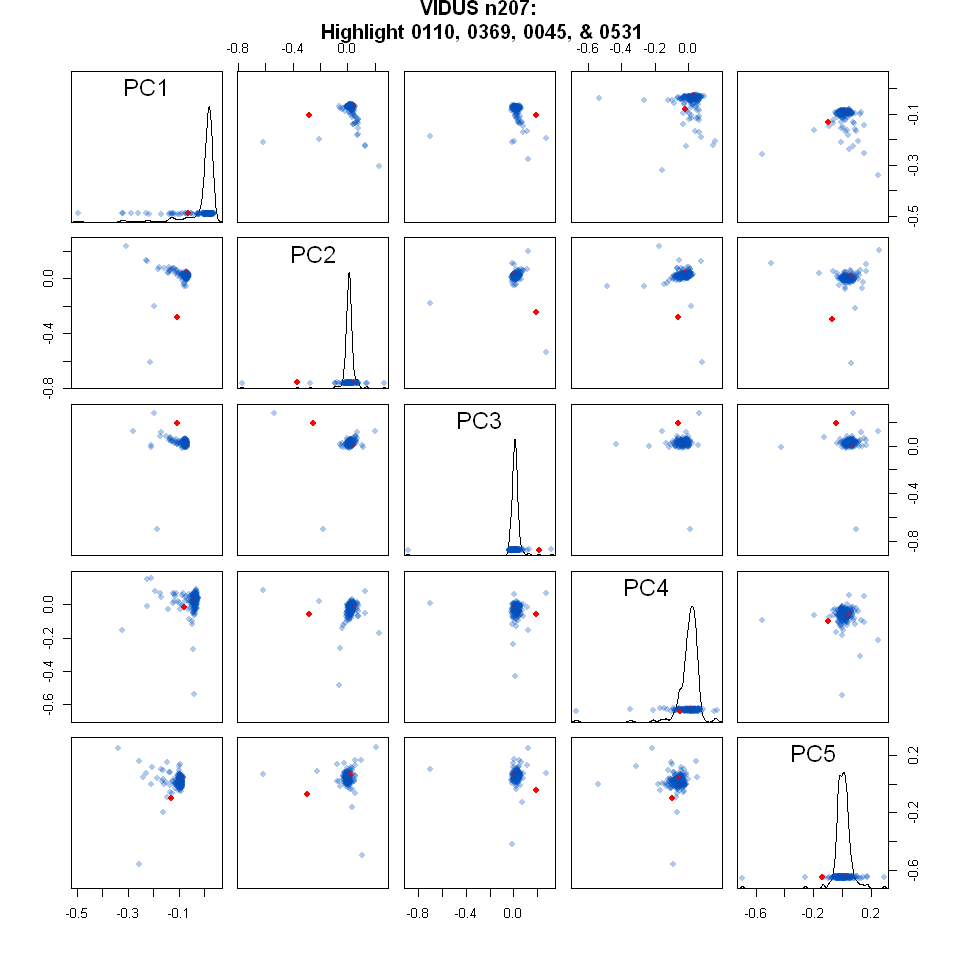

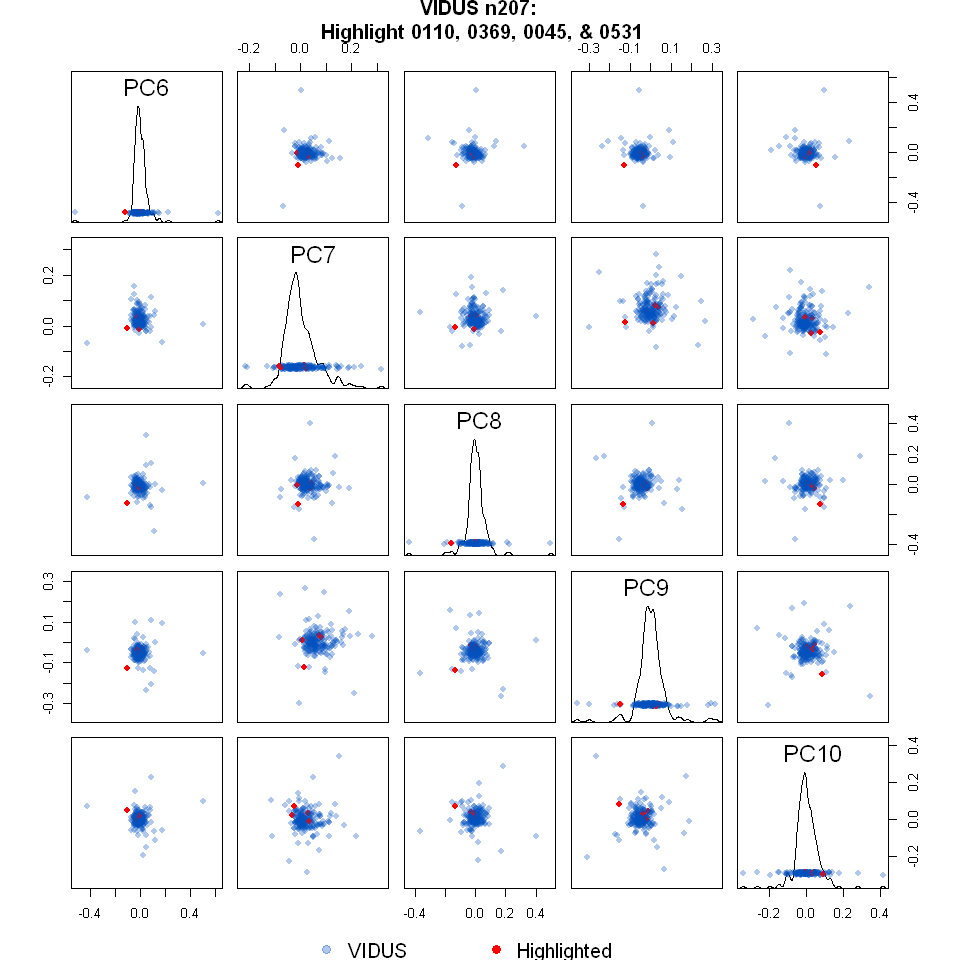

In [55]:
### R console ###
case_control <- FALSE # T or F
highlight_list <- c(181, 31, 148, 172) # integer based on order (e.g. highlight 3rd sample in list, put a 3)
plot_title <- "VIDUS n207:\n Highlight 0110, 0369, 0045, & 0531" 
legend_label <- "VIDUS"


# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label_colors){
    # Make x and y axes equal
    limits <- c(min(x, y), max(x, y)) * 1.3
    par(usr = c(limits, limits))
    points(x, y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label_colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    # Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    # Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label_colors, pch=16) # jitter adds random noise
}

# Run PCA and get % variance
ea_dspace <- ea_evec[1:10] #transformed dataspace
label_colors <- rep(NA, length(ea_dspace$V2)) # 

# different colors for cases and controls
if (case_control == TRUE) {
    sample_names <- ea_evec[,11]
    label_colors[grepl(x=sample_names, pattern="Case", ignore.case=T)] <- rgb(0,80,190,80, maxColorValue=255) #blue
    label_colors[grepl(x=sample_names, pattern="Control", ignore.case=T)] <- rgb(200,0,0,80, maxColorValue=255) #red
    legend_cols <- c(rgb(0,80,190,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255)) # blue
    legend_label <- c("Cases", "Controls")
    
} else{
    label_colors[] <- rgb(0,80,190,80, maxColorValue=255) #blue 
    legend_cols <- rgb(0,80,190,80, maxColorValue=255) # should match color directly above
    
    if ( length(highlight_list) >= 1) {
        legend_label = c(legend_label, "Highlighted")
        label_colors[highlight_list] <- rgb(255,0,0,255, maxColorValue=255) # red
        legend_cols <- c(rgb(0,80,190,80, maxColorValue=255),
                         rgb(255,0,0,255, maxColorValue=255)) # red
    }
}

#label_colors
#legend_cols

options(repr.plot.width=8, repr.plot.height=8)

# EV 1-5
par(oma = c(4, 1, 2, 1)) # Redefine outer margin
pairs(x=ea_dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", 
     yaxt = "n", main = plot_title, cex.main=1)

# EV 6-10
par(oma = c(4, 1, 2, 1)) 
pairs(x=ea_dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main=plot_title, cex.main=1)
legend("bottom", legend_label, 
       pch=19, col=legend_cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)

In [20]:
foo <- rep(NA, 10)
#foo[] = "jess"
foo[]

[1] NA NA NA NA NA NA NA NA NA NA

### Plot PVE
PVE of phenotype viral load wrt observed genotype data.

The phenotype file should be tab delimited. The order of the samples in the phenotype file and the genotype file (and as a consequence the PCA output file) are in the same order.

In [13]:
### Functions, Do not edit this cell ###
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[1]
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    #head(covar_data)
    
    } # end function


regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 0.9
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"), ylab="PVE")
    plot(cumsum(variance_explained$PVE), type="b", main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(variance_explained), cex.axis=cex.factor)

    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"), ylab="PVE")
    plot(cumsum(pve_sorted$PVE), type="b", main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted), cex.axis=cex.factor)
}


fid,iid,patid,matid,female,bin_vllog10_mean
8005964579_NA0054695_93-0482,8005964579_NA0054695_93-0482,NA,NA,0,3
8005964583_NA0053919_93-0005,8005964583_NA0053919_93-0005,NA,NA,0,3
8005964594_NA0054312_93-0257,8005964594_NA0054312_93-0257,NA,NA,0,3
8005964602_NA0054507_93-0379,8005964602_NA0054507_93-0379,NA,NA,1,3
8005964603_NA0054701_93-0488,8005964603_NA0054701_93-0488,NA,NA,0,5
8005964604_NA0054654_93-0109,8005964604_NA0054654_93-0109,NA,NA,0,2


MODEL FORMULA:

 bin_vllog10_mean~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EUR group ================
Top PCs:  PC1 PC5 PC8 
PVE:      81

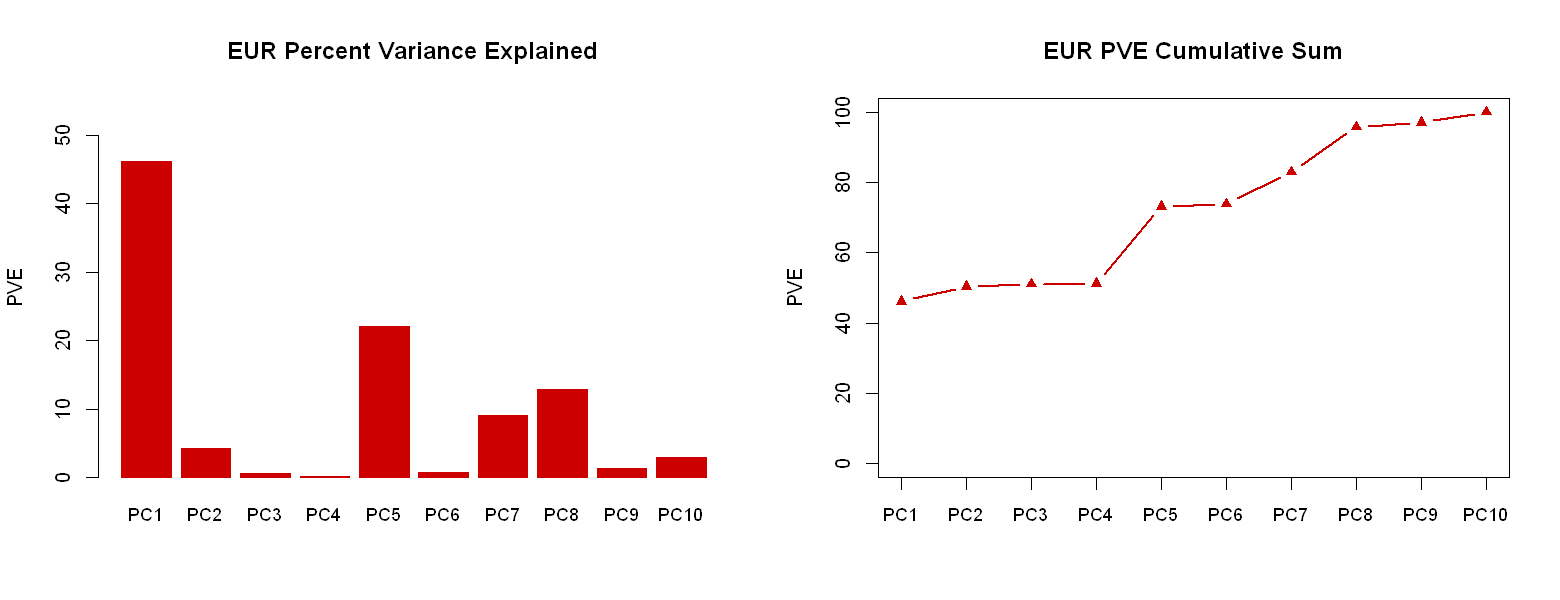

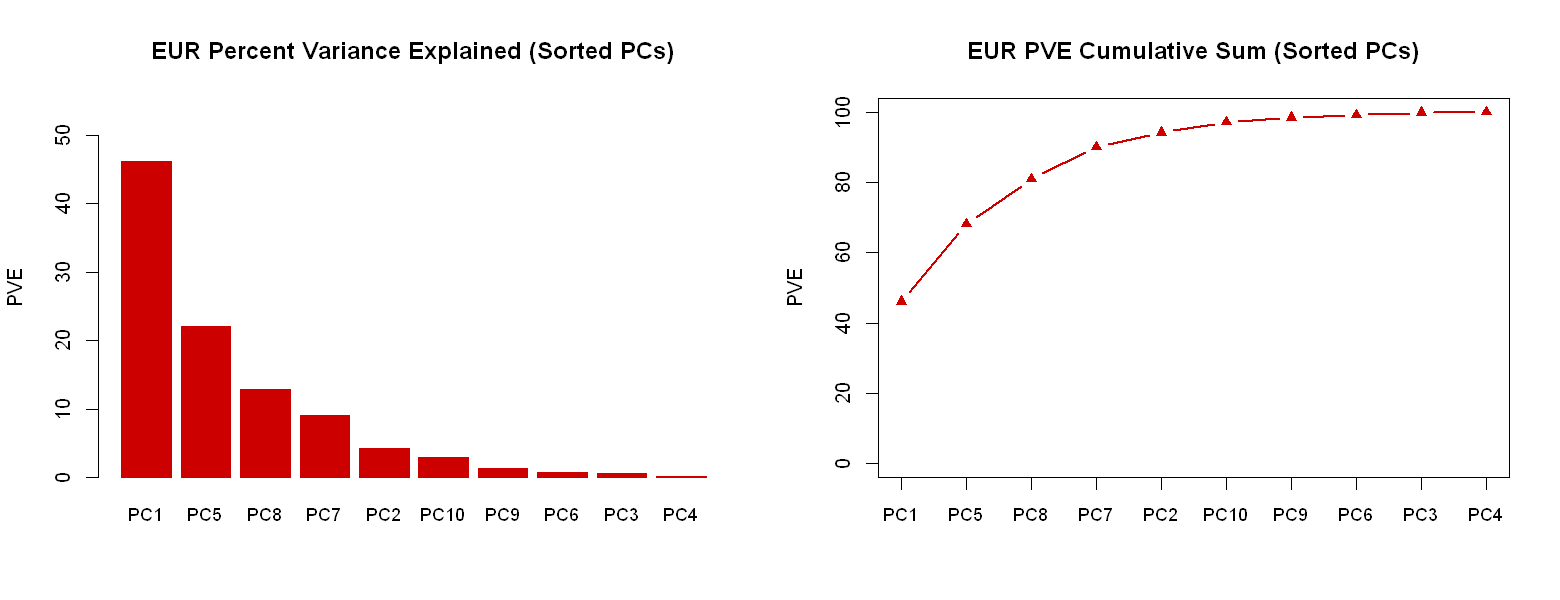

In [59]:
### R ###

## This code should be run in conjunction with the function from above ##

## All of the data should be in the working directory ##
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/troubleshooting/pca/20190725/n207")

study <- "VIDUS" # ALL_CAPS
ancestry <- "EUR" # EUR or AFR
phenotype <- "bin_vllog10_mean" # phenotype label in of header of phenotype file
sex_var <-  "female"   # sex label in  header of phenotype file
age_var <- "ageatint"  # age label in  header of phenotype file
phen_file <- "vidus_n207_final_binned.tsv" # name of phenotype file
pca_file <- "ea_ld_pruned_top10_eigenvecs.txt" # name of top 10 eigvec file
model_type <- "continuous" # continuous or logistic

################################################################################
################################################################################
covs <- c(sex_var, age_var) 
cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

### Table of eigenvalues
| EV1   | EV2   | EV3   | EV4   | EV5   | EV6   | EV7   | EV8   | EV9   | EV10  |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| 1.457 | 1.291 | 1.198 | 1.174 | 1.142 | 1.135 | 1.127 | 1.117 | 1.115 | 1.108 |